In [36]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import numpy as np

import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import Trainer

In [9]:
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, 'Dataset')

X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
X_test = np.load(os.path.join(data_dir,'X_test.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_test = np.load(os.path.join(data_dir,'y_test.npy'))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(988, 7, 7) (988,)
(421, 7, 7) (421,)


In [22]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([988, 7, 7]) torch.Size([988, 1])
torch.Size([421, 7, 7]) torch.Size([421, 1])


In [29]:
class LightningLSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(LightningLSTM, self).__init__()
        
        # Initialize LSTM layers
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True))
        for i in range(1, len(hidden_sizes)):
            self.lstm_layers.append(nn.LSTM(hidden_sizes[i-1], hidden_sizes[i], batch_first=True))
        
        # Initialize linear layers
        self.linear1 = nn.Linear(hidden_sizes[-1], 50)
        self.linear_output = nn.Linear(50, output_size)

        self.train_loss = []
        self.test_loss = []

    def forward(self, x):
        for lstm_layer in self.lstm_layers:
            x, _ = lstm_layer(x)
        
        # We take the output of the last time step
        x = x[:, -1, :]
        x = torch.relu(self.linear1(x))
        predictions = self.linear_output(x)
        return predictions

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        self.train_loss.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        self.test_loss.append(loss.item())

In [43]:
num_epochs = 50
model = LightningLSTM(input_size=7, hidden_sizes=[200, 100, 150, 50], output_size=1)
trainer = Trainer(max_epochs=num_epochs, enable_progress_bar=True)
trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/dare_devil/Documents/MLDS_2024/Quarter2/PredictiveAnalytics2/Project/Electricity-Power-Prediction/Modelling/lightning_logs

  | Name          | Type       | Params
---------------------------------------------
0 | lstm_layers   | ModuleList | 479 K 
1 | linear1       | Linear     | 2.6 K 
2 | linear_output | Linear     | 51    
---------------------------------------------
482 K     Trainable params
0         Non-trainable params
482 K     Total params
1.929     Total estimated model params size (MB)


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 52.06it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 50.01it/s, v_num=0]


In [44]:
trainer.test(model, test_loader)

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 183.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0028687920421361923   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0028687920421361923}]

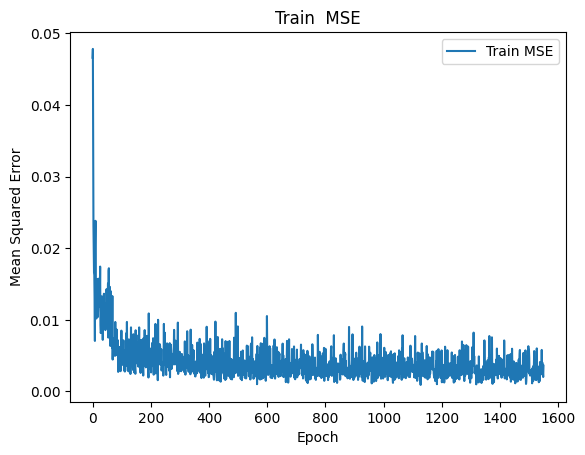

In [45]:
plt.plot(model.train_loss, label='Train MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Train  MSE')
plt.legend()
plt.show()